<a href="https://colab.research.google.com/github/danisJIOGUE/statistics-application/blob/master/predict_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default risk rating in non profit microfinance : case of non profit orgnisation KIVA

# Loading Databases

In [ ]:
#!pip install pycountry_convert
#!pip install langdetect
#!pip install nltk
#!pip install Wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
import pycountry_convert as pc
drive.mount('/content/drive')



from langdetect import detect

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Detection of the dataset'encoding
import chardet

#Loan dataset
with open("/content/drive/My Drive/Stat_App/loans.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.7291077209623456, 'encoding': 'ISO-8859-1', 'language': ''}

In [ ]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Description dataset
with open("/content/drive/My Drive/Stat_App/description.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [ ]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [ ]:
## We identify the variables which are the same in these databaes
loan.filter(items=db_desc.columns).columns

Index(['id', 'partner_id'], dtype='object')

In [ ]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [ ]:
db_desc.head(2)

,id,loan_name,description,description_translated,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,156,Marks Antonio,Through my association with the local elementa...,NaN,Purchase of tools and materials to full first ...,NI,Nicaragua,Managua,standard,NaN,5,6,1,NaN,Marks Antonio,male,true,monthly,field_partner
1,173,NaN,NaN,NaN,NaN,GZ,Gaza,NaN,standard,NaN,2,12,7,user_favorite,NaN,NaN,NaN,monthly,field_partner


In [ ]:
loan.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,362.0,50,05/06/2006,50,16/09/2006,12.150833,-86.268333


### Drop dupplicates observations

In [ ]:
## Number of dupplicates values (loan database)
loan.duplicated(subset=['id']).sum()

37177

In [ ]:
#stats desc on dupplicates obs
loan.loc[loan.id.duplicated()].count()

id                                        37177
description.languages                     26875
status                                    37177
funded_amount                             37177
paid_amount                               36671
activity                                  37177
sector                                    37177
location.country_code                     36312
location.country                          37177
location.town                             36536
location.geo.level                        37154
partner_id                                37154
borrowers.first_name                      37148
borrowers.last_name                       34912
borrowers.gender                          37107
borrowers.pictured                        37118
terms.disbursal_amount                    37105
terms.disbursal_currency                  37094
terms.disbursal_date                      37118
terms.loan_amount                         37107
terms.loss_liability.nonpayment         

In [ ]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [ ]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.reset_index(inplace=True)
data = data.drop('index',axis=1)
data.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,en,defaulted,600,NaN,Construction,Construction,NaN,Gaza,Rafah,town,2,Mansour,Al Nawajha,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


In [ ]:
data.shape

(5004, 42)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5004 non-null   object 
 1   description.languages                   3267 non-null   object 
 2   status                                  5004 non-null   object 
 3   funded_amount                           5004 non-null   object 
 4   paid_amount                             4904 non-null   object 
 5   activity                                5004 non-null   object 
 6   sector                                  5004 non-null   object 
 7   location.country_code                   4962 non-null   object 
 8   location.country                        5004 non-null   object 
 9   location.town                           4871 non-null   object 
 10  location.geo.level                      5002 non-null   obje

In [ ]:
#list of unuseful variables
unuseful = ['description.languages','activity','partner_id','location.geo.level','location.town','location.country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]

In [ ]:
data = data.drop(unuseful, axis = 1)
data.shape

(5004, 33)

In [ ]:
data.head(2)

,id,status,funded_amount,paid_amount,activity,sector,location.country,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,paid,500,500,Carpentry,Construction,Nicaragua,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,defaulted,600,NaN,Construction,Construction,Gaza,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


### Merge dataset laon with description

These dataset do not have the same size we are going to merge them

In [ ]:
resul = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [ ]:
resul.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'activity', 'sector',
       'location.country', 'borrowers.gender', 'borrowers.pictured',
       'terms.disbursal_amount', 'terms.disbursal_currency',
       'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'ta

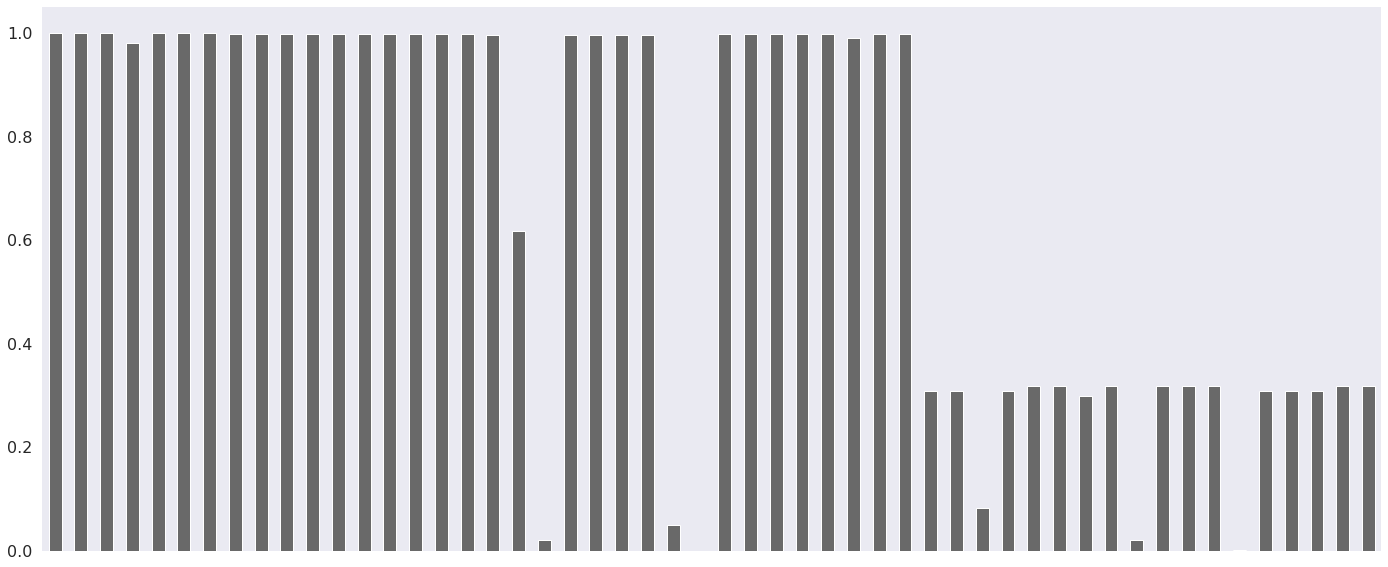

In [ ]:
# Missing values of the merging dataset
msno.bar(resul)

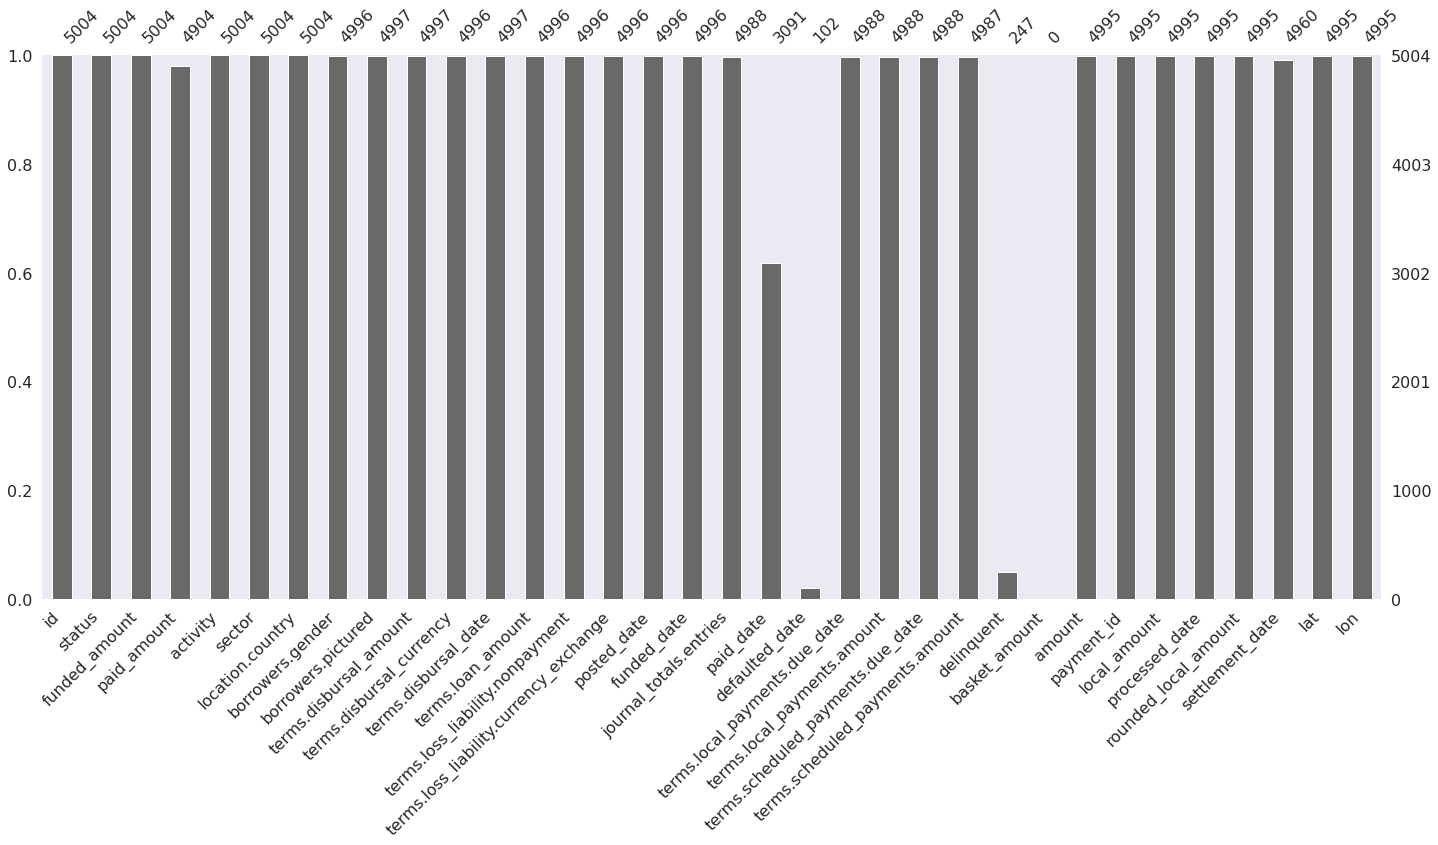

In [ ]:
# Missing value of the loan dataset
msno.bar(data)

With thses above graphics, we see that the merging dataset has many missing values. This contribute to reduce the information. We will use only the loan dataset.

# II) Explonatory data analysis
In this part we will find out the information behind the variables.

## Univariate analysis
### Qualitative variable
* Loan Status

In [ ]:
pd.crosstab(data.status,"freq")

col_0,freq
status,
101,1
F,1
defaulted,100
in_repayment,1818
paid,3084


In [ ]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [ ]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data = data[data.status != 'in_repayment']
data.shape

(3184, 33)

In [ ]:
conditions = [
    (data.status == 'defaulted'),
    (data.status == 'paid')
]
values = [1,0]

data['target'] = np.select(conditions, values)

In [ ]:
pd.crosstab(data.target,"freq")

col_0,freq
target,
0,3084
1,100


* Sector

In [ ]:
pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.02
Arts,3.11
Clothing,8.79
Construction,2.42
Education,0.13
Entertainment,0.09
Food,30.50
Health,0.94
Housing,0.82


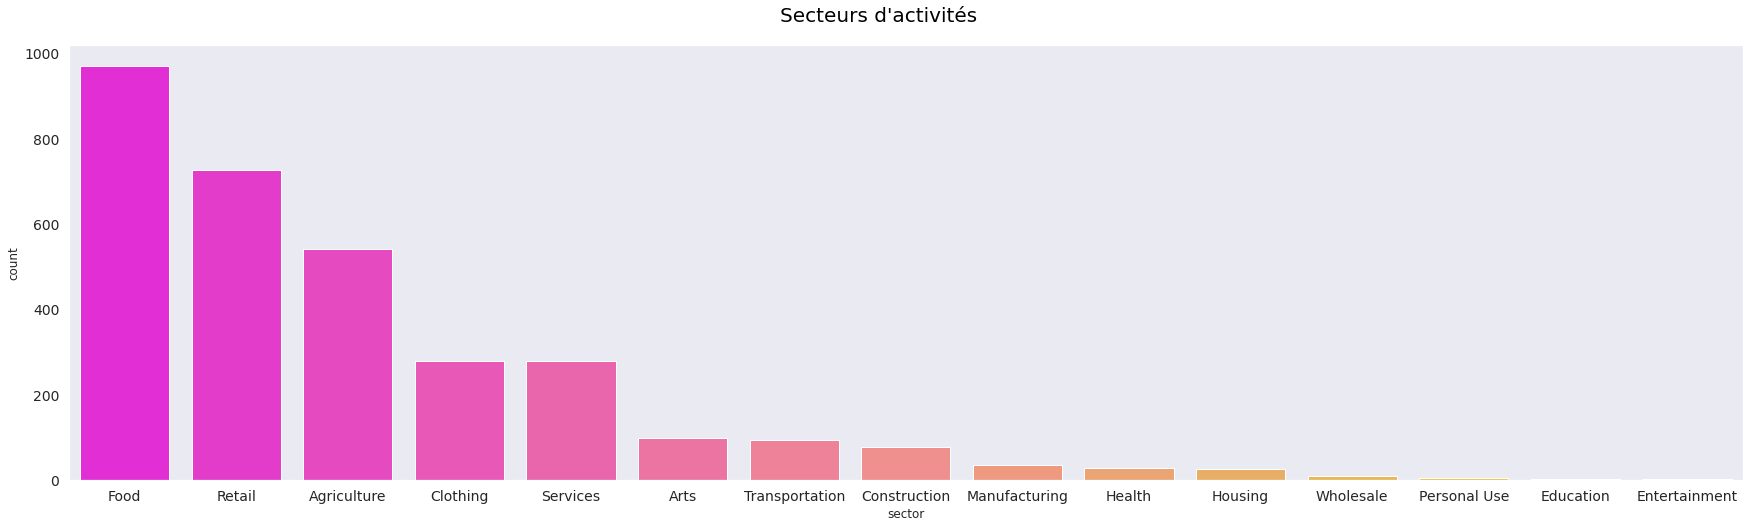

In [ ]:
plt.figure(figsize=(30,8))
sns.set(rc={"axes.grid":False,'xtick.labelsize':14,'ytick.labelsize':14})
plt.gcf().text(.5, .93, "Secteurs d'activités", fontsize = 20, color='black' ,ha='center', va='center')
ax = sns.countplot(x=data['sector'] , order =data['sector'].value_counts().index , palette="spring")

plt.show()

In [ ]:
Bien_Menage = ['Clothing','Housing','Personnal Use']
autre_secteur = ['Services','Education','Transportation','Arts','Health','Construction','Manufacturing','Entertainment','Wholesale']
conditions = [
    (data.sector == 'Agriculture'),
    (data.sector == 'Food'),
    (data.sector == 'Retail'),
    (data.sector == 'Clothing') | (data.sector == 'Housing') | (data.sector == 'Personal Use'),
    (data.sector == 'Services') | (data.sector == 'Education') | (data.sector == 'Transportation') | (data.sector == 'Arts') | (data.sector == 'Health') | (data.sector == 'Services') | (data.sector == 'Construction') |  (data.sector == 'Manufacturing') | (data.sector == 'Entertainment') | (data.sector == 'Wholesale')
]
values = ['Agriculture','Food','Retail','Bien_Menage','autre_secteur']
data.sector = np.select(conditions, values)

pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.02
Bien_Menage,9.80
Food,30.50
Retail,22.83
autre_secteur,19.85


* Borrower gender

In [ ]:
# Unique modalité of this variable
data.rename(columns={'borrowers.gender':'gender'}, inplace = True)
len(pd.unique(data['gender']))

3

In [ ]:
pd.crosstab(data['gender'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
gender,
F,79.77
M,20.13


In [ ]:
pd.crosstab(data['gender'].isna(),'freq')

col_0,freq
gender,
False,3181
True,3


We have 3 borroxers xho do not give the gender.

In [ ]:
# Suppression des missings values
data = data.dropna(how='all', subset=['gender'])

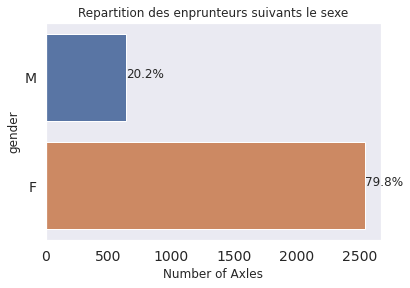

In [ ]:
ax = sns.countplot(y="gender", data=data)
plt.title('Repartition des enprunteurs suivants le sexe')
plt.xlabel('Number of Axles')

total = len(data['gender'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Countries repartition

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


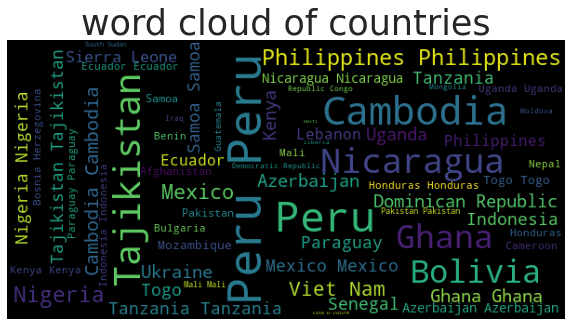

In [ ]:
# Wordcloud of the country
data.rename(columns={'location.country':'country_name'}, inplace = True)

names = data["country_name"][~pd.isnull(data["country_name"])]
#print(names)
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(names))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.title("word cloud of countries", fontsize=35)
plt.axis("off")
plt.show() 

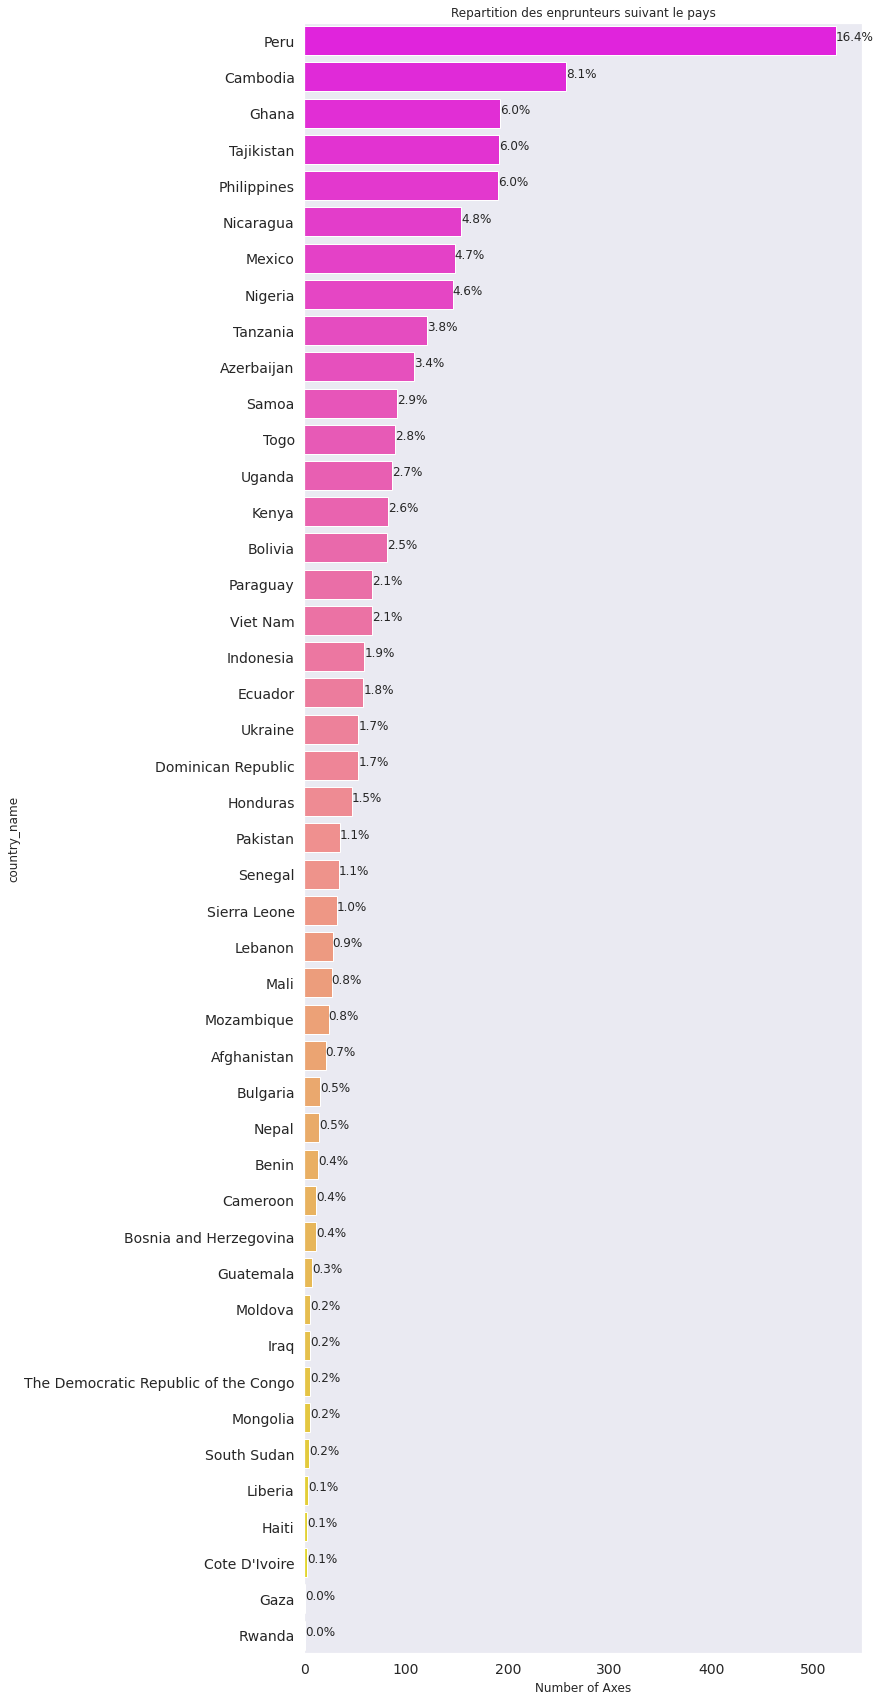

In [ ]:
plt.figure(figsize=(10,30))
ax = sns.countplot(y="country_name", data=data, order =data['country_name'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivant le pays')
plt.xlabel('Number of Axes')

total = len(data['country_name'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [ ]:
# grouping the country due to their continent
def pays_par_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'
    
data['CONTINENT'] = data['country_name'].apply(pays_par_continent)

#vérification du rendu :
data['CONTINENT'].unique()

array(['North America', 'Unknown', 'Africa', 'Europe', 'Asia', 'Oceania',
       'South America'], dtype=object)

In [ ]:
# We have the modality Unknown which we are going to give the real value
# looking for the country correspond to unknow
data[data['CONTINENT']=='Unknown']['country_name'].unique()

array(['Gaza', 'The Democratic Republic of the Congo', "Cote D'Ivoire"],
      dtype=object)

In [ ]:
data.CONTINENT = np.where((data.country_name == 'The Democratic Republic of the Congo') | (data.country_name == "Cote D'Ivoire"),'Africa',data.CONTINENT)
data.CONTINENT = np.where((data.country_name == 'Gaza'),'Asia',data.CONTINENT)

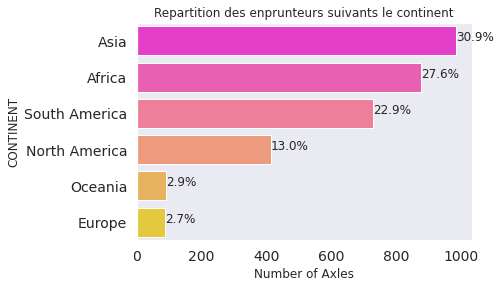

In [ ]:
#plt.figure(figsize=(10,30))
ax = sns.countplot(y="CONTINENT", data=data, order =data['CONTINENT'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivants le continent')
plt.xlabel('Number of Axles')

total = len(data['CONTINENT'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Borrower pictured

In [ ]:
data.rename(columns={'borrowers.pictured':'borrower_pictured'}, inplace = True)

pd.crosstab(data['borrower_pictured'],'freq').apply(lambda r: 100 * r/len(data), axis=1)

col_0,freq
borrower_pictured,
True,49.984282
FALSE,0.094310
TRUE,49.921408


In [ ]:
conditions = [
    (data.borrower_pictured == 'TRUE') | (data.borrower_pictured == 'True'),
    (data.borrower_pictured == 'FALSE')
]
values = ['TRUE','FALSE']

data['borrower_pictured'] = np.select(conditions, values)
pd.crosstab(data['borrower_pictured'],'freq')

col_0,freq
borrower_pictured,
0,1590
FALSE,3
TRUE,1588


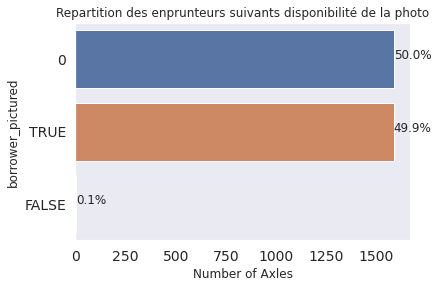

In [ ]:
ax = sns.countplot(y="borrower_pictured", data=data)
plt.title('Repartition des enprunteurs suivants disponibilité de la photo')
plt.xlabel('Number of Axles')

total = len(data['borrower_pictured'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Date of payment (funded date, posted date)

In [ ]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT'],
      dtype='object')

In [ ]:
# Conversion des variables en datetime

data["posted_date"] = pd.to_datetime(data["posted_date"])
data["funded_date"] = pd.to_datetime(data["funded_date"])
data["terms.disbursal_date"] = pd.to_datetime(data["terms.disbursal_date"])
data["settlement_date"] = pd.to_datetime(data["settlement_date"])

data["posted_date"].dt
data["funded_date"].dt
data["terms.disbursal_date"].dt
data["settlement_date"].dt

# Ajout des variables années à notre dataset
data["posted_date"] = data["posted_date"].dt.year
data["funded_date"] = data["funded_date"].dt.year
data["terms.disbursal_date"] = data["terms.disbursal_date"].dt.year
data["settlement_date"] = data["settlement_date"].dt.year

# Définition des variables pour la représentation graphique
df1 = pd.crosstab(data["posted_date"],"freq")
df2 = pd.crosstab(data["funded_date"],"freq")
df3 = pd.crosstab(data["terms.disbursal_date"],"freq")
df4 = pd.crosstab(data["settlement_date"],"freq")

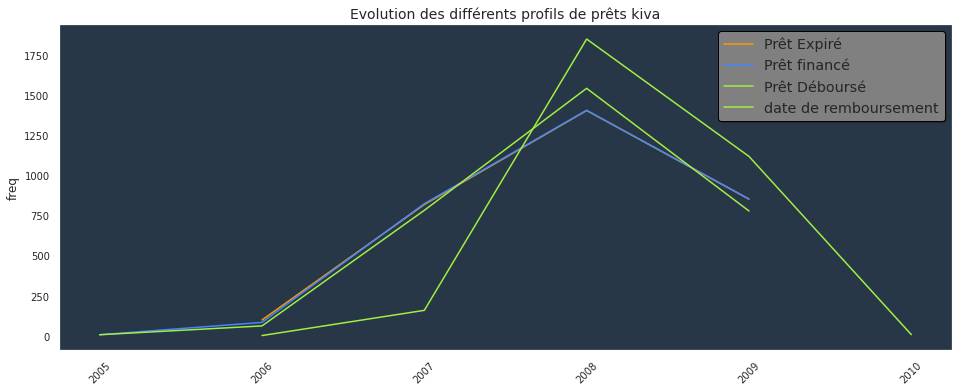

In [ ]:
plt.figure(figsize=(16,6))
sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("Evolution des différents profils de prêts kiva",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df1.index.values, y = df1['freq'] , color = '#ff9900' , label= 'Prêt Expiré')
sns.lineplot(x = df2.index.values, y = df2['freq'] , color = '#4586ff' , label = 'Prêt financé')
sns.lineplot(x = df3.index.values, y = df3['freq'] , color = '#a2ef44' , label = 'Prêt Déboursé')
sns.lineplot(x = df4.index.values, y = df4['freq'] , color = '#a2ef44' , label = 'date de remboursement')
plt.legend(facecolor= 'grey' , fontsize='large' , edgecolor = 'black' ,shadow=True) # Legend formatting
plt.show()

### Quantitative variable

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3181 non-null   object 
 1   status                                  3181 non-null   object 
 2   funded_amount                           3181 non-null   object 
 3   paid_amount                             3081 non-null   object 
 4   sector                                  3181 non-null   object 
 5   country_name                            3181 non-null   object 
 6   gender                                  3181 non-null   object 
 7   borrower_pictured                       3181 non-null   object 
 8   terms.disbursal_amount                  3181 non-null   object 
 9   terms.disbursal_currency                3181 non-null   object 
 10  terms.disbursal_date                    3181 non-null   int6

In [ ]:
data['funded_amount'] = pd.to_numeric(data['funded_amount'], downcast='float')
data['paid_amount'] = pd.to_numeric(data['paid_amount'], downcast='float')

In [ ]:
numerical_col = data.select_dtypes(include =["number"]).columns.values
numerical_col

array(['funded_amount', 'paid_amount', 'terms.disbursal_date',
       'terms.loan_amount', 'posted_date', 'funded_date',
       'journal_totals.entries', 'basket_amount', 'amount', 'payment_id',
       'settlement_date', 'lat', 'lon', 'target'], dtype=object)

In [ ]:
def Num_info(df, numeric_column):
  """ Fonction qui affiche les infos sur les variables quantitatives
    le nombre de missings et leur pourcentage"""
  df_result = pd.DataFrame(columns=["columns","null_values","null_percent"])
    
  df_temp=pd.DataFrame()
  for value in numeric_column:

    df_temp["columns"] = [value]
    df_temp["null_values"] = df[value].isna().sum()
    df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
    df_result = df_result.append(df_temp)
    
  df_result.sort_values("null_values", ascending =False, inplace=True)
  df_result.set_index("columns", inplace=True)
  return df_result

In [ ]:
df_num = Num_info(data,numerical_col)
df_num

,null_values,null_percent
columns,,
basket_amount,3181,100.0
paid_amount,100,3.1
settlement_date,35,1.1
funded_amount,0,0.0
terms.disbursal_date,0,0.0
terms.loan_amount,0,0.0
posted_date,0,0.0
funded_date,0,0.0
journal_totals.entries,0,0.0


In [ ]:
var_quanti = ['amount','paid_amount','funded_amount','journal_totals.entries']
data[var_quanti].describe()

,amount,paid_amount,funded_amount,journal_totals.entries
count,3181.000000,3081.000000,3181.000000,3181.000000
mean,107.415929,681.986389,680.084900,1.454574
std,142.532848,600.016907,593.962952,0.672619
min,0.080000,25.000000,25.000000,1.000000
25%,42.000000,325.000000,325.000000,1.000000
50%,69.000000,525.000000,525.000000,1.000000
75%,110.000000,900.000000,900.000000,2.000000
max,1818.100000,5000.000000,5000.000000,7.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

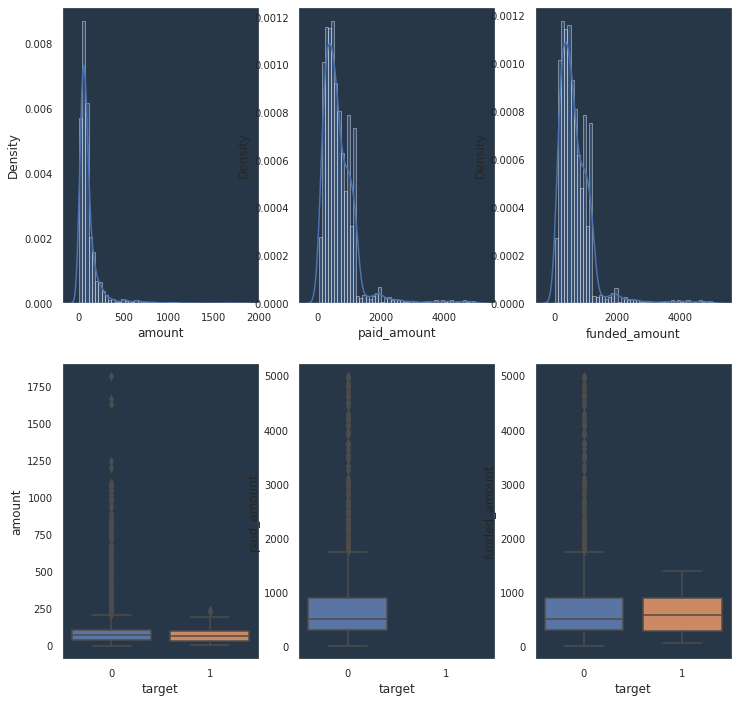

In [ ]:
numerical_cols1 = ['amount','paid_amount','funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,3,i)
    sns.distplot(data[col])
    plt.subplot(2,3,3+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

In [ ]:
# Remplacement des données 95% percetile value
Q4 = data['paid_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de paid_amount est de : ",len(data[data['paid_amount'] >= Q4]))
data.loc[data['paid_amount'] >= Q4, 'paid_amount'] = Q4 # outlier capping

Q4 = data['funded_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de funded_amount est de :",len(data[data['funded_amount'] >= Q4]))
data.loc[data['funded_amount'] >= Q4, 'funded_amount'] = Q4 # outlier capping

Le nombre total de paid_amount est de :  357
Le nombre total de funded_amount est de : 370


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


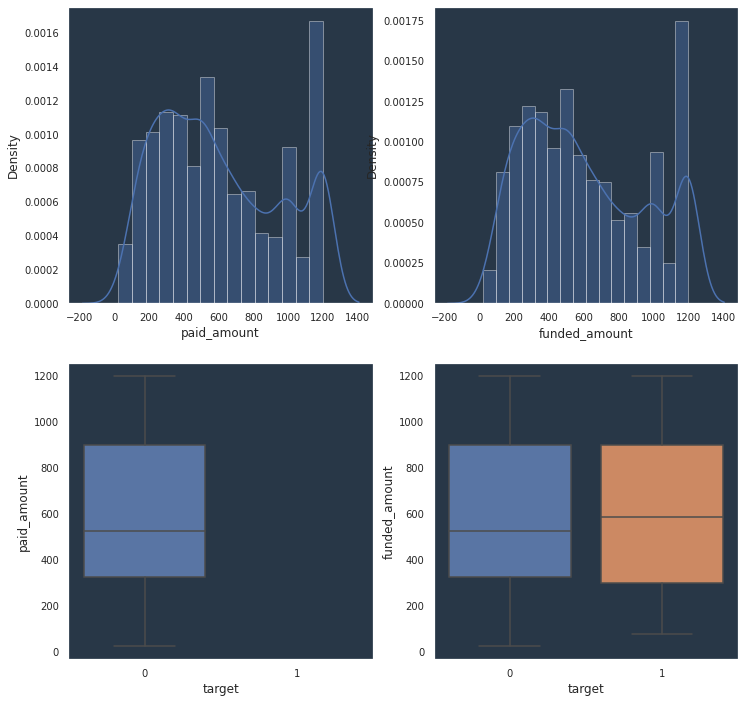

In [ ]:
numerical_cols1 = ['paid_amount', 'funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,2,i)
    sns.distplot(data[col])
    plt.subplot(2,2,2+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

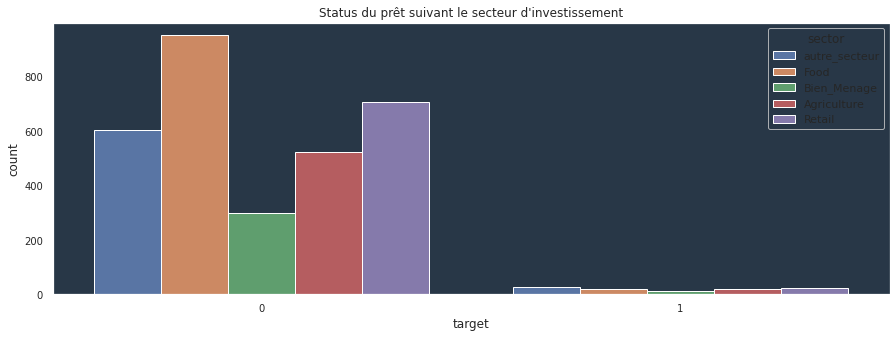

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="target", hue='sector', data=data).set_title("Status du prêt suivant le secteur d'investissement");

## re-sampling

As we saw in statistic of the target variable, we only have 100 defaulted observation,
that is while we are going to re-sample the dataset to have at list the same number of
inrepayment and default.

In [ ]:
data.target.unique()

array([0, 1])

In [ ]:
data_def = data.loc[data.target==1]
data_rep = data.loc[data.target==0]
print('Base repayment : ', data_rep.shape,'\nBase default : ',data_def.shape)

Base repayment :  (3081, 35) 
Base default :  (100, 35)


In [ ]:
data_rep = data_rep.sample(n=100, replace = False)

In [ ]:
final = data_def.append(data_rep)

In [ ]:
pd.crosstab(final.target,'y')

col_0,y
target,
0,100
1,100


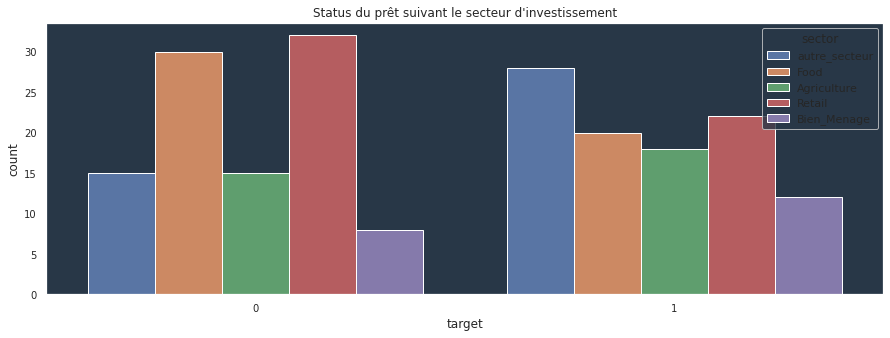

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="target", hue='sector', data=final).set_title("Status du prêt suivant le secteur d'investissement");

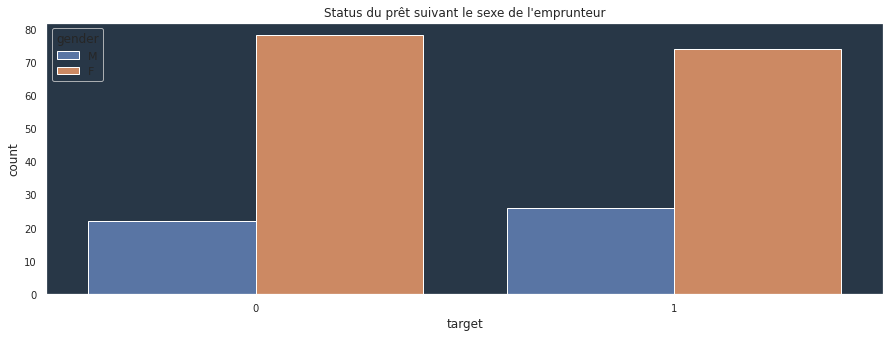

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="target", hue='gender', data=final).set_title("Status du prêt suivant le sexe de l'emprunteur");

In [ ]:
col_quant = ['target','amount','paid_amount','funded_amount','journal_totals.entries']
final[col_quant].groupby('target').describe()

amount                                    ... journal_totals.entries                    
        count      mean         std   min   25%  ...                    min  25%  50%  75%  max
target                                           ...                                           
0       100.0  121.3200  177.695376  7.69  42.0  ...                    1.0  1.0  1.0  2.0  5.0
1       100.0   71.1861   47.282314  6.49  30.0  ...                    1.0  1.0  1.0  1.0  7.0

[2 rows x 32 columns]

# NLP
The purpose of this part is to better understand the use of the loan. So, we will use this algorithm to have all the information in the use of loan. To archieving our target we are going to :
- Detect the languages of the description
- Tokens all the observation
- Delect the stop words

In [ ]:
# Looking for missing values
description = resul['loan_use'].tolist()
desc_pb = []
for myst in description:
    if isinstance(myst,float): # Les variables nan sont de type float 
        desc_pb.append(myst)

print(' We have ', len(desc_pb),' missing values.')

 We have  1644  missing values.


In [ ]:
resul = resul.dropna(how='all', subset=['loan_use'])

# Show one example of the loan use
resul.at[10,'loan_use']

'New refrigerator'

In [ ]:
# The length of loan use description 
resul['length'] = resul['loan_use'].map(len,)

#groupby loan depending on the status of the borrower
resul.groupby('target').length.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,1540.0,42.486364,27.493714,4.0,25.0,38.0,51.0,491.0


As we can see only the entrepreneurs who are not in default situation pay give the use of their loan. We are going to search for the informations which are containing in this description.

In [ ]:
resul.reset_index(inplace=True)

In [ ]:
# Fonction for looking for the mistake in the language detection algorithm 
texte_decrip = resul['loan_use']
langdet = []                                                    

for i in range(len(resul)):                                         
    try:                                                          
       lang=detect(texte_decrip[i])                                      
    except:                                                       
       lang='no'                                                  
       print("This row throws error:", texte_decrip[i])                 
    langdet.append(lang)   

In [ ]:
langdet
output = []
for x in langdet:
    if x not in output:
        output.append(x)
print(' The differents languages which are using to describe the loan are : ',output,
     '\n The number of this languages are :',len(output))

 The differents languages which are using to describe the loan are :  ['en', 'tl', 'es', 'ca', 'af', 'id', 'so', 'no', 'sv', 'fr', 'it', 'de', 'fi', 'et', 'da', 'tr', 'ro', 'pt', 'lt', 'cy', 'pl', 'nl', 'vi', 'sk', 'hr'] 
 The number of this languages are : 25


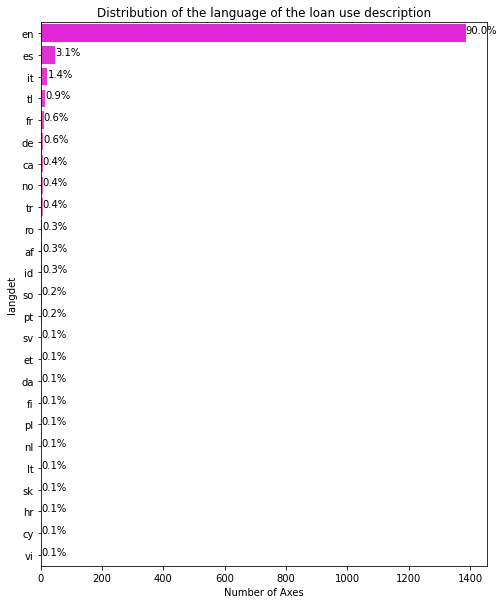

In [ ]:
resul['langdet'] = pd.DataFrame({'langue':langdet})
#pd.crosstab(resul['langdet'],'freq').apply(lambda r: 100 * r/len(resul), axis=1).round(2)

plt.figure(figsize=(8,10))
ax = sns.countplot(y="langdet", data=resul, order =resul['langdet'].value_counts().index , palette="spring")
#ax = sns.countplot(x=loan_copy['SECTOR_NAME'] )

plt.title('Distribution of the language of the loan use description')
plt.xlabel('Number of Axes')

total = len(resul['langdet'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [ ]:
# We will have a description only for english language
database_eng = resul[['loan_use','langdet']]
database_eng = database_eng[database_eng['langdet'] == 'en']
database_eng.reset_index(inplace=True)

## Tokenisation

In [ ]:
tokens = []
for i in range(len(database_eng)):
    tokens.append(nltk.tokenize.word_tokenize(database_eng['loan_use'][i]))
    
# Adding token variable in the dataset
database_eng['tokens'] = tokens

In [ ]:
# Suppression of stops words
# uploading the corpus of english's stop-words
stop_words = set(nltk.corpus.stopwords.words('english'))
database_eng['filtered_text'] = database_eng['tokens'].map(lambda tokens: [w for w in tokens if not w in stop_words])

# Print the previous text without tokens
print(database_eng['tokens'][3],end='\n\n')
print(database_eng['filtered_text'][3],end='\n\n')
print("Mots différents :", set(database_eng['tokens'][3]) - set(database_eng['filtered_text'][3]))

['Buy', 'inventory', 'like', 'bread', ',', 'ham', ',', 'pens', 'and', 'paper', ',', 'medicine', ',', 'juices', ',', 'and', 'the', 'like', '.']

['Buy', 'inventory', 'like', 'bread', ',', 'ham', ',', 'pens', 'paper', ',', 'medicine', ',', 'juices', ',', 'like', '.']

Mots différents : {'and', 'the'}


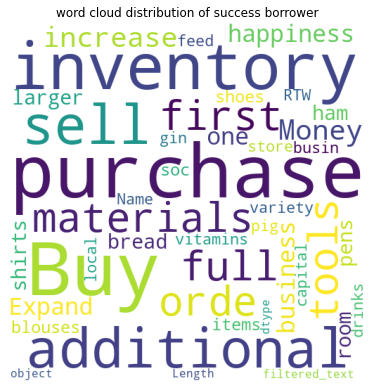

In [ ]:
database_eng['target'] = resul['target']
spam_words = ''.join(str(database_eng[database_eng['target']==0]['filtered_text']))
spam_cloud = WordCloud(width = 512,height = 512,background_color="white", collocations = True).generate(spam_words)
plt.figure(figsize = (5, 8), facecolor ='w')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("word cloud distribution of success borrower")
plt.show()

In [ ]:
msno.heatmap(resul)

In [ ]:
pd.crosstab(resul.status,"freq")

In [ ]:
resul['close_date'] = np.where(resul["defaulted_date"].isnull(), resul["paid_date"], resul["defaulted_date"] )

In [ ]:
msno.bar(resul)

In [ ]:
msno.bar(resul)

In [ ]:
pd.crosstab(resul.status,resul.delinquent)

In [ ]:
# We drop some variables with too many missing values
var_to_delete = ['basket_amount','repayment_interval','defaulted_date', 'paid_date','delinquent']
resul = resul.drop(var_to_delete, axis=1)

In [ ]:
test = resul.dropna(axis=0)
test.shape

In [ ]:
pd.crosstab(test.status,"freq")
# Only paid observations have missing values 

In [ ]:
resul = resul.dropna(axis=0)

In [ ]:
msno.bar(resul)
# we are going to work with this database

### Target variable

In [ ]:
resul.head()

In [ ]:
resul.info()

In [ ]:
resul = resul.drop('terms.disbursal_amount', axis=1)

In [ ]:
resul['funded_amount'] = pd.to_numeric(resul['funded_amount'], downcast='float')

# Categorical variables

In [ ]:
resul.sector.value_counts()

Food              951
Retail            715
Agriculture       533
Clothing          278
Services          266
Arts               94
Transportation     92
Construction       75
Manufacturing      35
Health             30
Housing            25
Wholesale          11
Personal Use        6
Education           4
Entertainment       2
Name: sector, dtype: int64

In [ ]:
categorical_var = ['sector', 'location.country','location.town', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date','borrowers.gender', 'borrowers.pictured','close_date']
date_var = ['terms.disbursal_date','posted_date', 'funded_date','close_date']
resul[categorical_var] = resul[categorical_var].astype('category')
resul['borrowers.gender'] = resul['borrowers.gender'].cat.codes
resul['borrowers.pictured'] = resul['borrowers.pictured'].cat.codes
resul['terms.loss_liability.nonpayment'] = resul['terms.loss_liability.nonpayment'].cat.codes

In [ ]:
# We can group the sector variable
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
resul['sector_cat'] = np.where(resul['sector'].isin(others), "Other", resul['sector'])

In [ ]:
# We can also group the country variable
def country_to_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'
    
resul['continent'] = resul['location.country'].apply(country_to_continent)

In [ ]:
#We can create dummy variables
resul = pd.get_dummies(resul, columns=['sector_cat','continent'], prefix = ['sector','continent'])
resul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 5000
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   id                               3117 non-null   object  
 1   funded_amount                    3117 non-null   float32 
 2   status                           3117 non-null   object  
 3   sector                           3117 non-null   category
 4   location.country                 3117 non-null   category
 5   location.town                    3117 non-null   category
 6   terms.disbursal_date             3117 non-null   category
 7   terms.loss_liability.nonpayment  3117 non-null   int8    
 8   posted_date                      3117 non-null   category
 9   funded_date                      3117 non-null   category
 10  amount                           3117 non-null   float64 
 11  borrowers.gender                 3117 non-null   int8    
 12  borrow

In [ ]:
resul

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,close_date,target,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Food,sector_Manufacturing,sector_Other,sector_Retail,sector_Services,sector_Transportation,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_Unknown
0,156,500.0,paid,Construction,Nicaragua,Managua,14/04/2005,1,15/02/2006,31/03/2005,50.00,1,0,1.0,16/09/2006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,173,600.0,defaulted,Construction,Gaza,Rafah,14/04/2005,0,15/02/2006,31/03/2005,50.00,1,0,7.0,11/09/2007,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,183,500.0,paid,Food,Honduras,Siguatepeque,14/04/2005,1,15/03/2006,31/03/2005,35.00,0,0,2.0,21/11/2006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,200,575.0,paid,Services,Kenya,Ongata Rongai,14/04/2005,1,15/03/2006,31/03/2005,114.00,0,0,2.0,02/05/2007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
5,213,225.0,paid,Food,Honduras,Danli,14/04/2005,1,15/03/2006,31/03/2005,40.00,1,0,1.0,28/11/2006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,102400,150.0,paid,Retail,Philippines,Purok 9b Kiwalan. Iligan City,15/04/2009,1,17/04/2009,17/04/2009,7.89,0,0,2.0,15/09/2009,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4995,102453,350.0,paid,Food,Nigeria,Lagos State,01/04/2009,1,17/04/2009,17/04/2009,43.75,0,0,1.0,15/12/2009,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4998,102713,225.0,paid,Agriculture,Philippines,Cebulin. Plaridel. Misamis Occidental,20/03/2009,1,18/04/2009,18/04/2009,28.12,0,0,2.0,15/09/2009,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4999,102744,75.0,paid,Clothing,Philippines,Bacolod. Ozamiz City. Mis. Occ.,31/03/2009,1,18/04/2009,18/04/2009,12.05,0,0,2.0,16/10/2009,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Prediction model

## re-sampling

As we saw in statistic of the target variable, we only have 100 defaulted observation,
that is while we are going to re-sample the dataset to have at list the same number of
inrepayment and default.

In [ ]:
resul.target.unique()

array([0, 1])

In [ ]:
data_def = resul.loc[resul.target==1]
data_rep = resul.loc[resul.target==0]
print('Base repayment : ', data_rep.shape,'\nBase default : ',data_def.shape)

Base repayment :  (3017, 33) 
Base default :  (100, 33)


In [ ]:
data_rep = data_rep.sample(n=100, replace = False)

In [ ]:
final = data_def.append(data_rep)

In [ ]:
pd.crosstab(final.target,'y')

col_0,y
target,
0,100
1,100


# Modelisation

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
Y = final['target']
X = final.drop(['id','target','status','location.town','location.country','sector', 'sector_Agriculture', 'continent_Africa'], axis=1)
X = X.drop(date_var, axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(150, 21)
(50, 21)


In [ ]:
## Confusion matrix 
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(Y_test,Y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[26,  1],
       [ 4, 19]])

Text(0.5, 257.44, 'Predicted label')

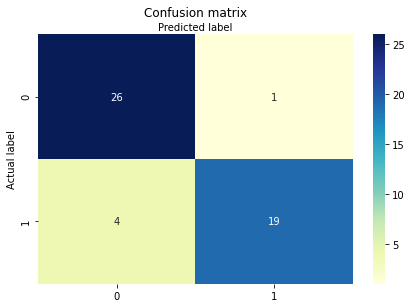

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))

Accuracy: 0.9
Precision: 0.95
Recall: 0.8260869565217391


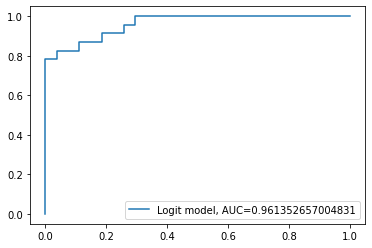

In [ ]:
# ROC Curve
Y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="Logit model, AUC="+str(auc))
plt.legend(loc=4)
plt.show()